# human case

In [ ]:
ftp://ftp-trace.ncbi.nih.gov/1000genomes/ftp/data/NA12878/alignment/
    
convert cram to bam for cnvnator
and convert bam to bed for sequana_coverage.



In [42]:
import pandas as pd
%pylab inline
rcParams['figure.figsize'] = (10,8)

Populating the interactive namespace from numpy and matplotlib


# sequana_coverage and CNVnator analysis

## sequana_coverage

Because the data input files are huge and the analysis takes a while for this 3.5Gb genome, we designed a snakemake pipeline available in sequana (http://sequana.readthedocs.io/en/master/index.html) and in the directory ./coverage/. It can be run using snakemake. For instance on a slurm scheduler, we used:

    srun -c 1 snakemake -s coverage.rules -p --cluster "sbatch --mem 8000 " -j 30

The config file is also available in ./coverage and looks like

```
input_directory: ''
input_readtag: _R[12]_
input_extension: ''
input_pattern: /pasteur/homes/tcokelae/TEMP/coverage/NA12878.bed
input_samples:
    file1: ''
    file2: ''
coverage:
    circular: true
    double_threshold: 0.5
    genbank_file: ''
    high_threshold: 6.0
    low_threshold: -4.0
    mixture_models: 2
    reference_file: ''
    window: 250001
    chunksize: 10000000
    binning: 100
    cnv_delta: 1000
```

One can run the analyse of each chromososme one by one using the standalone, but here we can take advantage of a cluster 
and parallelise each chromosome analysis. This took less than 1 hour to analyse the 24 chromosomes. We provide the final rois.csv in this directory together with the multiqc_report.html file that was generated by sequana_coverage. Note that we do not provide the individual HTML reports (too large) but only the ROIs files and the summary files (json format). 

Note that we provided an input file called NA.bed.chrom_names.txt that contains the list of 24 chromosomes of interests and represents of 90% of the data. We ignored the other contigs for convenience. CNVnator analysis (here below) takes into account all chromosomes.


# Performances

- cnvnator used about 6.5Gb and finished in XX hours using bin parameter of 100. 
- sequana_coverage uses 2Gb at max and took about 1 hour with each chromosome analysed on 1 node. The overall computation time would thereferore be 24 times 1 hour at max. (this is using a binning of 100)

There is lots of place for improvments because most of the time is spent in IO while reading the input file. For instance doing the analysis of chromosome 21 only via a shell (or using the standalone), the analysis takes one minute  on a single node (SSD disk, using a binning of 100). The extrapolation to all 24 chromosomes indicates that we could therefore analyse the data in 3.5Gb / 46.7Mb * 1 minute = 75 minutes

# comparison on chromosome chr21

## sequana ROIs

In [35]:
rois = pd.read_csv("coverage/coverage_reports/chr21/rois.csv")
rois = rois.drop("Unnamed: 0", axis=1)
print("Sequana identified {} ROIS amongst which {} with length >= 800".format(len(rois), len(rois.query("size > 800"))))

Sequana identified 1071 ROIS amongst which 226 with length >= 800


## cnvnator ROIs

In [36]:
from sequana.cnv import CNVnator
cnvnator = CNVnator("events_bin100.txt").df.query("name=='chr21'")
print("cnvnator identified {} ROIs with size>800".format(len(cnvnator)))

cnvnator identified 127 ROIs with size>800


It is not easy to validate one or the other set of ROIs. Some events clearly overlaps. Some events are seen by one tool and not the other, and vice versa.

One general trend is that sequana_coverage detects many small events. Some are just noise, some are real events. 

The best is to give a set of representative examples. Interested reader can then explore farther what comparison could be done.

In [100]:
from sequana import GenomeCov
b = GenomeCov("NA12878_chr21.bed")
c = b.chr_list[0]
c.thresholds.high = 6
c.run(250000, 2, binning=100, cnv_delta=1000)    
c.rois.df = c.rois.df.query("size>15")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [103]:
def plot_rois(x1, x2, chrom, cnvnator):
    chrom.plot_rois(x1,x2)
    for _, item in cnvnator.query("size<1000000").iterrows():
        if item['type'] == "deletion":
            fill_between([item.start, item.end], [600,600], color="green", alpha=0.5)
        else:
             fill_between([item.start, item.end], [600,600], color="red", alpha=0.5)
        ylim([0,600])

# 5Mb to 5.5Mb

(-10, 100)

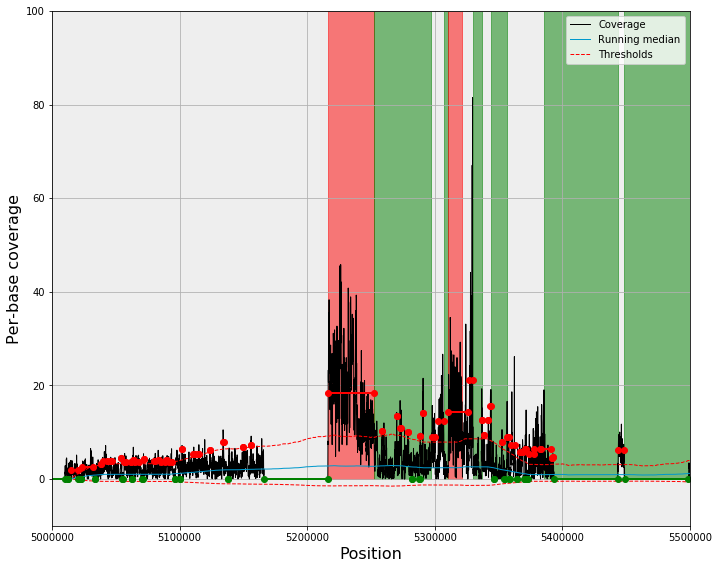

In [104]:
plot_rois(5000000, 5500000, c, cnvnator)
ylim([-10, 100])

- red and blue area correponds to identifier regions in CNVnator. 
- red and green dots (or  horizontal lines) are those identified by Sequana_coverage

- we see that sequana_coverage has many short detections. Those events can be clustered or filtered out depending on the needs.

- We see also that the first red area or the second red areas are classified similarly by CNVnator and sequana_coverage.

- The event on the right hand side at position 5,450,000 is detected by sequana as a CNV but missed somehow by CNVnator that may be misled by the two empty areas around it.

Let us now focus on 5,200,000 to 5,400,000

# 5.2Mb to 5.4Mb

(-10, 100)

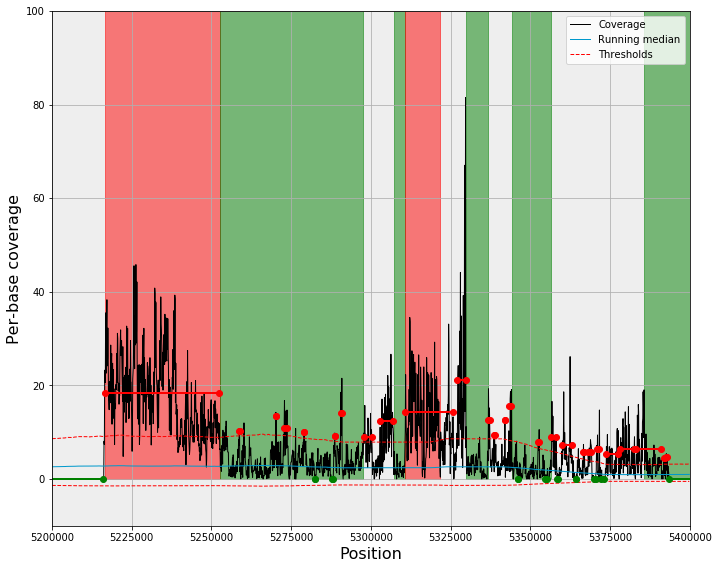

In [105]:
plot_rois(5200000, 5400000, c, cnvnator)
ylim([-10, 100])

as mentionned above, the two red regions detected are compatible with the outcome of sequana_coverage. 
However, concerning the green areas, this could be questionned. Let us look at the first one in 5.25 to 5.3Mb. Here there is an alternance
of deleted regions and outliers (red dots). By eyes there is no clear pattern except that this area is surrounded by two red regions
(excess of DOC). However, the green area itself has a DOC of around 5, which is consistent with the overall DOC.

# 5.6Mb to 6.3Mb

(-1, 15)

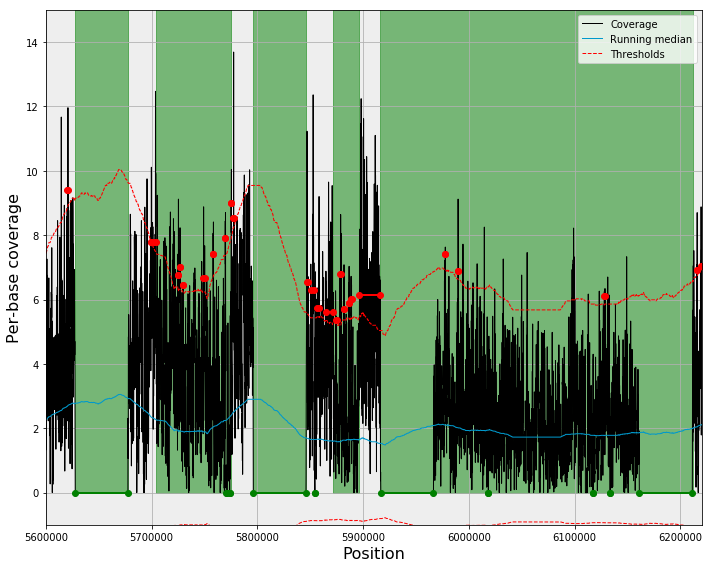

In [106]:
plot_rois(5600000,6220000,c, cnvnator)
ylim((-1,15))

Here, there is an alternance of deleted regions. The large deleted are detected by CNVnator and sequana_coverage.

More interestingly, let us look at the green regions where the DOC is not zero:
    - in sequana, again, there are lots of small detected events (red dots). Most of them could be ignored except 
      maybe the ones at position 5,900,000 that could be considered as a CNV with a CN of 1.25 (average DOC is about 4.9)
    - in cnvnator, the entire region from 5900000 to 6200000 is green meaning there is no difference here in the deleted regions and the one in the middle, which could be questionned. 
    - In the green region in the middle (position 5900000), cnvnator identifies a depleted region surrounded by two normal (white regions) and this seems a sensible choice. Sequana does not classify this region. 
      

# 6.5Mb to 7.4Mb

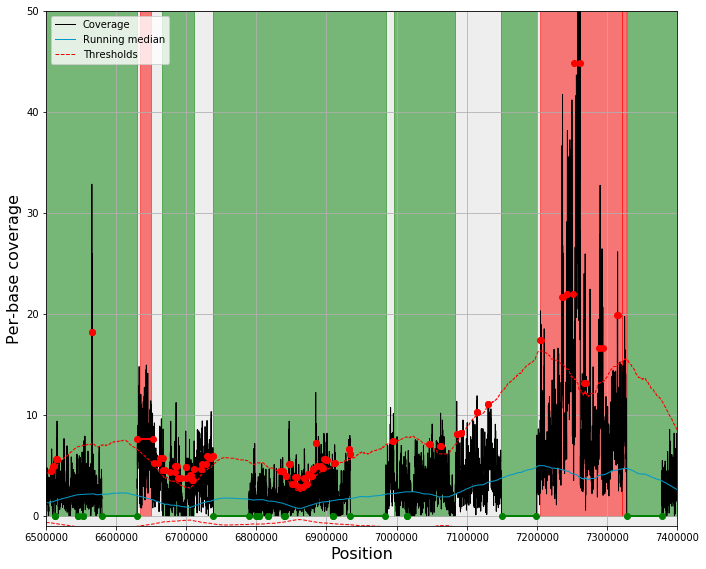

In [107]:
plot_rois(6500000,7400000, c, cnvnator)
_ = ylim([-1,50])

- again, alternance of CNVs. At position 6.75Mb to 7Mb, the deleted region reported by CNVnator englobes 2 deleted regions and the
region in the middle and classify this as one event
- CNVnator identifies a CNV like event (duplication) in the right hand side. Indeed, the CN is about 2 here. With sequana_coverage, this is 
  not clear due to the fact that the running median follows the data. One would need to increaese the window parameter and find 
    clustering more suitable. Note however that the red dots here have large zscore.
- an event detected in sequana is not seen in cnvnator (left hand side at position 6550000). This is a very short but string event.


# 12.5Mb to 15Mb

(-1, 40)

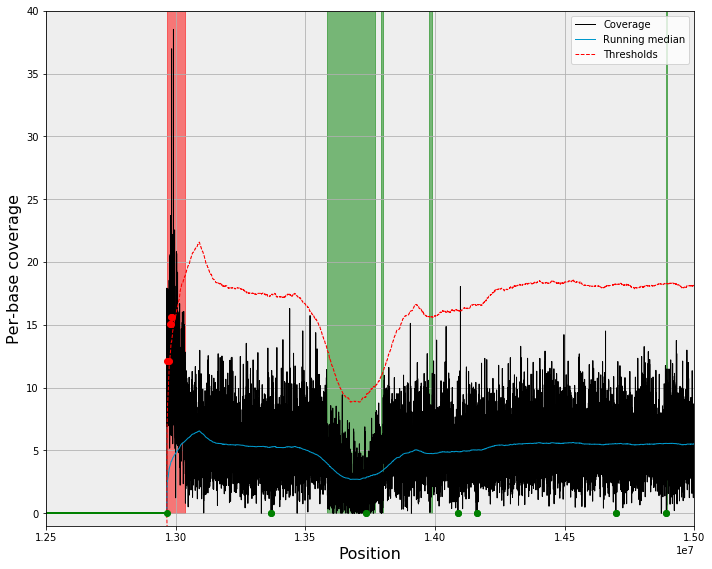

In [108]:
plot_rois(12500000, 15000000, c, cnvnator)
ylim([-1,40])

Here, the red and green area are detected by the two tools.


In [109]:
# 15Mb to 20Mb

(-1, 20)

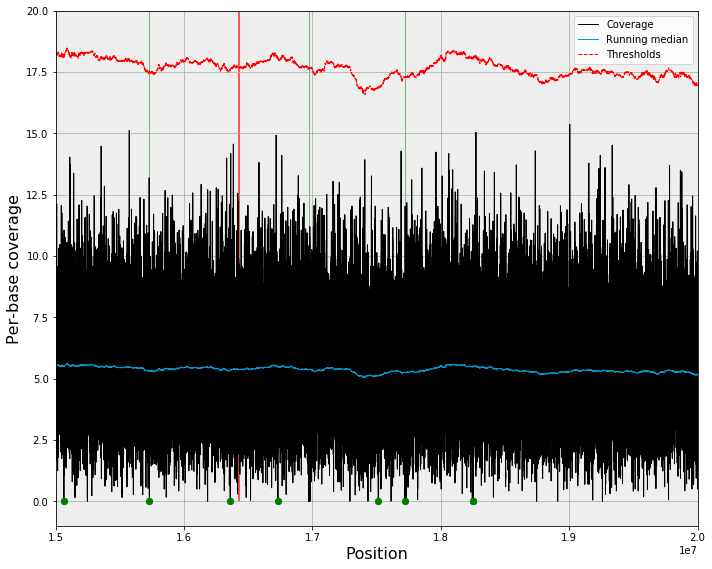

In [110]:
plot_rois(15000000,20000000, c, cnvnator)
ylim(-1,20)

No detection in sequana_coverage in this clean data set match with cnvnator. 
As for the 4 events detected by cnvnator, there are short but of interest. Note however, that sequana_coverage allows the detection of shorter events (filtered out for convenience in the plots). 

(0, 120)

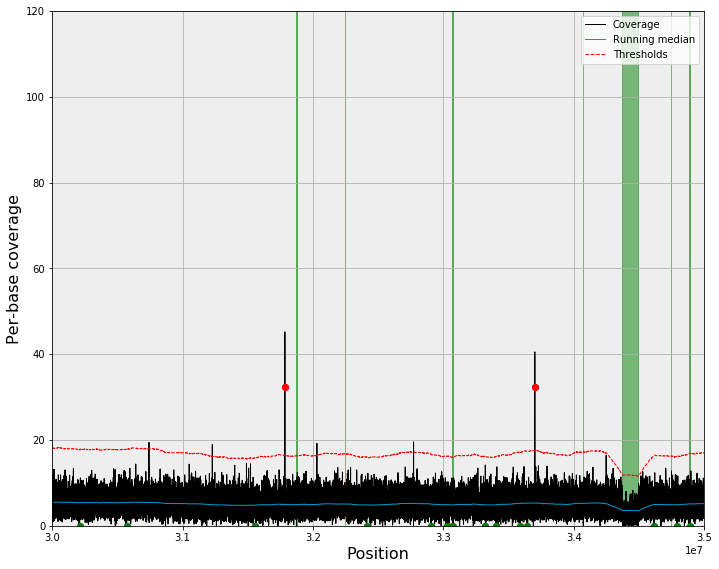

In [111]:
plot_rois(30000000,35000000, c, cnvnator)
ylim([0,120])

Here, the event of the right hand side (125,000 bases long) is missed by sequana_coverage. We recommend to use W = 2 times the CNV length to be detected. This is due to the low depth of coverage. Future versions could use a more appropriate clustering and detection procedure for low coverage. Note here, that sequana_coverage detects 2 additional strong but short events .

# Conclusion

- CNVnator is a robust tool, fast to run and is designed to analyse whome genome. 
- Sequana_coverage for the analysis of human genome is less mature and there still place for improvements in terms performance. However, it is fast enough that it can be used to analyse whole genome as well
- in this notebook we looked at the chr21 chromosome to compare the two tools. We believe that the two tools could be used to confirm events and to complement themselves. 
